## Data 

In [25]:
from torchvision.datasets import MNIST 
from torchvision import transforms 
from torch.utils.data import DataLoader
import torch 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [26]:
class Flatten(torch.nn.Module):
  def forward(self,img):
    img_shape = img.shape
    return img.view(img_shape[0],img_shape[1]*img_shape[2])

In [27]:
mnist_tnfs = transforms.Compose([transforms.ToTensor(),Flatten()])

In [28]:
train,valid = MNIST('.', train=True, download=True,transform=mnist_tnfs), MNIST('.', train=False, download=True,transform=mnist_tnfs)


In [29]:
def get_dl(train_ds, valid_ds,bs,**kwargs):
  return (DataLoader(train_ds,bs,shuffle=True, drop_last=True),
  DataLoader(valid_ds,bs*2,shuffle=False))

In [30]:
bs = 128
train_dl, valid_dl = get_dl(train,valid,bs)

In [31]:
xb,yb = next(iter(valid_dl))

In [32]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs*2,1,28*28)
assert yb.shape==(bs*2,)

tensor(7)

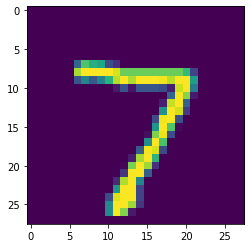

In [33]:
import matplotlib.pyplot as plt

plt.imshow(xb[0].view(28,28))
yb[0]

In [34]:
len(train.classes)

10

## Utils

In [35]:
class DataBunch():
  def __init__(self,train_dl,valid_dl,c=None):
    self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
  @property
  def train_ds(self):return self.train_dl.dataset
  
  @property
  def valid_ds(self):return self.valid_dl.dataset
    

In [36]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [37]:
n,m = train.data.shape[0],train.data.shape[1]*train.data.shape[2]
c = len(train.classes)
nh = 10

lr = 0.01   # learning rate
epochs = 30 # how many epochs to train for
n,m,c,lr,epochs

(60000, 784, 10, 0.01, 30)

In [38]:
data = DataBunch(train_dl, valid_dl,c)

In [39]:
class MNISTNN(torch.nn.Module):
  def __init__(self,m,nh,c):
    super(MNISTNN, self).__init__()
    self.lin1 = torch.nn.Linear(m,nh)
    self.batchnorm1 = torch.nn.BatchNorm1d(nh)
    self.act1 = torch.nn.ReLU()
    self.out = torch.nn.Linear(nh,10)
  
  def forward(self,xb):
    xb = xb.squeeze(1)
    return self.out(self.act1(self.batchnorm1(self.lin1(xb))))

In [40]:
lin1_stats = []
def note_op_percentile(self, input, output):
  if self.training:
    p = output.quantile(torch.tensor([0.15,0.5,0.85]))
    lin1_stats.append({
        "mean": output.mean(),
        "15_per": p[0].item(),
        "50_per": p[1].item(),
        "85_per": p[2].item(),
    })


In [41]:
def get_model(nh):
    model = MNISTNN(m,nh,c)
    model.batchnorm1.register_forward_hook(note_op_percentile)
    return model, torch.optim.SGD(model.parameters(), lr=lr)

In [42]:
model,opt = get_model(50)

In [43]:
model, opt

(MNISTNN(
   (lin1): Linear(in_features=784, out_features=50, bias=True)
   (batchnorm1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (act1): ReLU()
   (out): Linear(in_features=50, out_features=10, bias=True)
 ), SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [44]:
loss_func = F.cross_entropy

In [45]:
data.train_ds

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Flatten()
           )

In [46]:
def get_model(data,lr=0.01,nh=50):
  m = data.train_ds[0][0].shape[1]
  model = MNISTNN(m,nh,data.c)
  return model, torch.optim.SGD(model.parameters(), lr=lr)

In [47]:
class Learner():
  def __init__(self,model,opt,loss_func,data):
    self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [48]:
learn = Learner(*get_model(data), loss_func, data)

## Training Loop

In [51]:

def fit(epochs, learn):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        learn.model.train()
#         print(model.training)
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [52]:
loss,acc = fit(1, learn)

0 tensor(0.4939) tensor(0.8962)


# CallBacks and Runner

In [54]:
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [56]:
#export
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

In [55]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [59]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

In [60]:
#export
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [61]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [62]:
run.fit(2, learn)

train: [0.44263269147302353, tensor(0.9002)]
valid: [0.3530154296875, tensor(0.9165)]
train: [0.34697442992120725, tensor(0.9144)]
valid: [0.2958839111328125, tensor(0.9257)]


In [66]:
from functools import partial

In [67]:
acc_cbf = partial(AvgStatsCallback,accuracy)

In [68]:
run = Runner(cb_funcs=acc_cbf)

In [69]:
run.fit(1, learn)

train: [0.3012490883851663, tensor(0.9236)]
valid: [0.262426904296875, tensor(0.9309)]


In [70]:
run.avg_stats.valid_stats.avg_stats

[0.262426904296875, tensor(0.9309)]

## Anealing CallBacks 

In [71]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [72]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [73]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [115]:
f = sched_lin(1,2)
f(0.0001)

1.0001

In [75]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

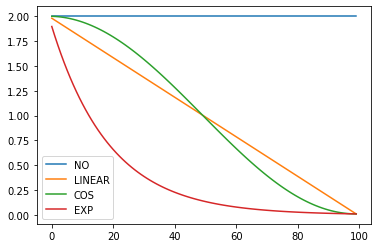

In [77]:
import math 
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [163]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    len_pct = len(pcts)
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == len_pct: idx = len_pct - 1
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [170]:
from torch import tensor
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

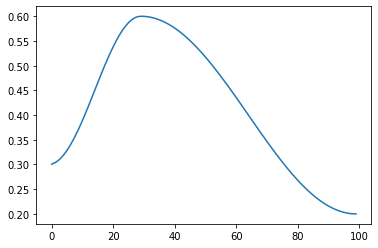

In [171]:
plt.plot(a, [sched(o) for o in p])

In [172]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)
run.fit(15, learn)

train: [0.2857128697582799, tensor(0.9212)]
valid: [0.15933204345703125, tensor(0.9506)]
train: [0.14463714860443377, tensor(0.9583)]
valid: [0.1241042236328125, tensor(0.9650)]
train: [0.11042678865612063, tensor(0.9675)]
valid: [0.1212298095703125, tensor(0.9626)]
train: [0.09212354513315055, tensor(0.9724)]
valid: [0.09777811889648437, tensor(0.9716)]
train: [0.0781917979574611, tensor(0.9760)]
valid: [0.09330798950195313, tensor(0.9720)]
train: [0.0638839852096688, tensor(0.9810)]
valid: [0.08526217651367188, tensor(0.9741)]
train: [0.05450977423252203, tensor(0.9838)]
valid: [0.08626258544921875, tensor(0.9737)]
train: [0.048189208038851745, tensor(0.9854)]
valid: [0.08409776000976563, tensor(0.9739)]
train: [0.04163065934792543, tensor(0.9873)]
valid: [0.07963447875976562, tensor(0.9766)]
train: [0.03454330232408312, tensor(0.9896)]
valid: [0.0801895263671875, tensor(0.9764)]
train: [0.02961105566758376, tensor(0.9917)]
valid: [0.07912893676757812, tensor(0.9775)]
train: [0.02638

In [166]:
from torch import tensor 
sched = combine_scheds([0.2, 0.3,0.2,0.3], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2),sched_cos(0.2, 0.6),sched_cos(0.6, 0.2)]) 

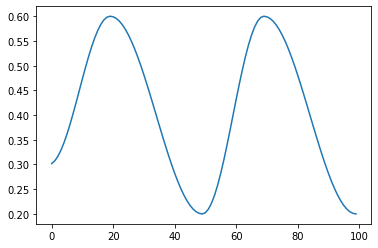

In [167]:
plt.plot(a, [sched(o) for o in p])


In [90]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy)]
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)
run.fit(3, learn)

train: [0.28330370911166197, tensor(0.9202)]
valid: [0.1679108154296875, tensor(0.9498)]
train: [0.14845802437545907, tensor(0.9565)]
valid: [0.1277565185546875, tensor(0.9626)]
train: [0.11213714240962623, tensor(0.9670)]
valid: [0.11625550537109375, tensor(0.9655)]


In [169]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)
run.fit(30, learn)

train: [0.2785739083575387, tensor(0.9228)]
valid: [0.16334993896484376, tensor(0.9523)]
train: [0.14828752044938567, tensor(0.9569)]
valid: [0.123369580078125, tensor(0.9640)]
train: [0.11510193653595753, tensor(0.9659)]
valid: [0.12049925537109375, tensor(0.9628)]
train: [0.09578294020432693, tensor(0.9713)]
valid: [0.10927376708984375, tensor(0.9678)]
train: [0.08195296719542935, tensor(0.9760)]
valid: [0.12580643310546874, tensor(0.9603)]
train: [0.07210364708533654, tensor(0.9786)]
valid: [0.09627208251953125, tensor(0.9716)]
train: [0.06140597661336263, tensor(0.9807)]
valid: [0.08652312622070313, tensor(0.9754)]
train: [0.05306789202567858, tensor(0.9839)]
valid: [0.09074552001953125, tensor(0.9729)]
train: [0.04501550625532101, tensor(0.9860)]
valid: [0.0940199951171875, tensor(0.9734)]
train: [0.03864673875335954, tensor(0.9880)]
valid: [0.08452244262695313, tensor(0.9757)]
train: [0.033235390981038414, tensor(0.9903)]
valid: [0.08386468505859375, tensor(0.9753)]
train: [0.027

KeyboardInterrupt: ignored

train: [0.2771256601708567, tensor(0.9231)]
valid: [0.16224552001953124, tensor(0.9520)]
train: [0.132921259627383, tensor(0.9609)]
valid: [0.11013072509765626, tensor(0.9669)]
train: [0.09056260035588191, tensor(0.9738)]
valid: [0.0957315185546875, tensor(0.9713)]


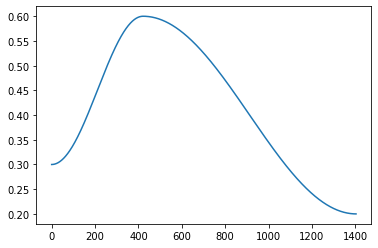

In [88]:
run.recorder.plot_lr()

In [84]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [85]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [140]:
# def combine_scheds(pcts, scheds):
pcts,scheds = [0.2, 0.3,0.2,0.3], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2),sched_cos(0.2, 0.6),sched_cos(0.6, 0.2)]
# pcts,scheds = [0.3,0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]


In [141]:
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    

In [142]:
pcts

tensor([0.0000, 0.2000, 0.5000, 0.7000, 1.0000])

In [157]:
def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == 4: idx = 3
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)


In [158]:
pos = 1.00

In [159]:
idx = (pos >= pcts).nonzero().max()

In [160]:
(pos >= pcts).nonzero().max()

tensor(4)

In [161]:
p

tensor([0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800, 0.0900,
        0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700, 0.1800,
        0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600, 0.2700,
        0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500, 0.3600,
        0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400, 0.4500,
        0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300, 0.5400,
        0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200, 0.6300,
        0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100, 0.7200,
        0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000, 0.8100,
        0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900, 0.9000,
        0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800, 0.9900,
        1.0000])

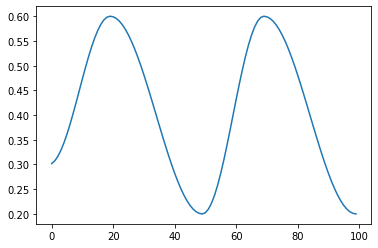

In [162]:
plt.plot(a, [_inner(o) for o in p])